In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from statsmodels.regression import linear_model
from statsmodels.api import add_constant

from scipy.linalg import sqrtm

sns.set_context('talk')

In [2]:
DEMAN_REGS = False  # flag for remeaning the regressors so that they don't compete with the intercept. Doesn't really do anything!

# 1. Look at the predicted factors

In [3]:
cond_info = {
    # G1 conditions, slightly reordered from the original PNAS paper, to be alphabetical, since the LDA classifier orders the labels
    'CCl_BR_e': {'Task': 'CCl', 'Stim': 'BR', 'Resp': 'TR', 'SR-Conj': 'BRTR', 'odd_even': 'even'},
    'CCl_BR_o': {'Task': 'CCl', 'Stim': 'BR', 'Resp': 'TR' , 'SR-Conj': 'BRTR', 'odd_even': 'odd'},

    'CCl_TL_e': {'Task': 'CCl', 'Stim': 'TL', 'Resp': 'BL', 'SR-Conj': 'TLBL', 'odd_even': 'even'},
    'CCl_TL_o': {'Task': 'CCl', 'Stim': 'TL',  'Resp': 'BL', 'SR-Conj': 'TLBL', 'odd_even': 'odd'},
    
    'Cl_BR_e': {'Task': 'Cl', 'Stim': 'BR', 'Resp': 'BL', 'SR-Conj': 'BRBL', 'odd_even': 'even'},
    'Cl_BR_o': {'Task': 'Cl', 'Stim': 'BR', 'Resp': 'BL', 'SR-Conj': 'BRBL', 'odd_even': 'odd'},

    'Cl_TL_e': {'Task': 'Cl', 'Stim': 'TL', 'Resp': 'TR', 'SR-Conj': 'TLTR', 'odd_even': 'even'},
    'Cl_TL_o': {'Task': 'Cl', 'Stim': 'TL', 'Resp': 'TR', 'SR-Conj': 'TLTR', 'odd_even': 'odd'},
    
    'H_BR_e': {'Task': 'H', 'Stim': 'BR', 'Resp': 'BL', 'SR-Conj': 'BRBL', 'odd_even': 'even'},
    'H_BR_o': {'Task': 'H', 'Stim': 'BR', 'Resp': 'BL', 'SR-Conj': 'BRBL', 'odd_even': 'odd'},

    'H_TL_e': {'Task': 'H', 'Stim': 'TL', 'Resp': 'TR', 'SR-Conj': 'TLTR', 'odd_even': 'even'},
    'H_TL_o': {'Task': 'H', 'Stim': 'TL', 'Resp': 'TR', 'SR-Conj': 'TLTR', 'odd_even': 'odd'},
    
    'V_BR_e': {'Task': 'V', 'Stim': 'BR', 'Resp': 'TR', 'SR-Conj': 'BRTR', 'odd_even': 'even'},
    'V_BR_o': {'Task': 'V', 'Stim': 'BR', 'Resp': 'TR', 'SR-Conj': 'BRTR', 'odd_even': 'odd'},

    'V_TL_e': {'Task': 'V', 'Stim': 'TL', 'Resp': 'BL', 'SR-Conj': 'TLBL', 'odd_even': 'even'},
    'V_TL_o': {'Task': 'V', 'Stim': 'TL', 'Resp': 'BL', 'SR-Conj': 'TLBL', 'odd_even': 'odd'},
    

    # G2 not coded, unecessary for the current analysis
    
}

cond_order = list(cond_info.keys())
cond_order

['CCl_BR_e',
 'CCl_BR_o',
 'CCl_TL_e',
 'CCl_TL_o',
 'Cl_BR_e',
 'Cl_BR_o',
 'Cl_TL_e',
 'Cl_TL_o',
 'H_BR_e',
 'H_BR_o',
 'H_TL_e',
 'H_TL_o',
 'V_BR_e',
 'V_BR_o',
 'V_TL_e',
 'V_TL_o']

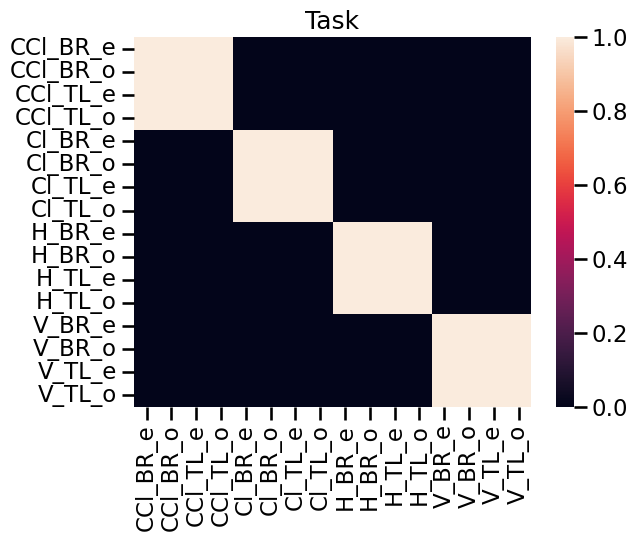

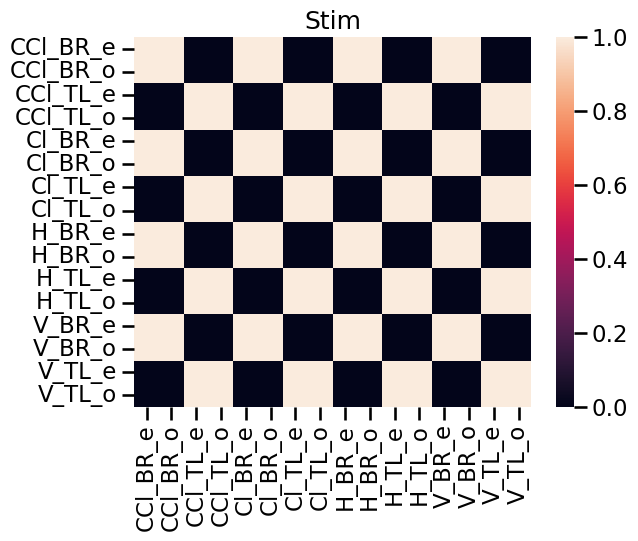

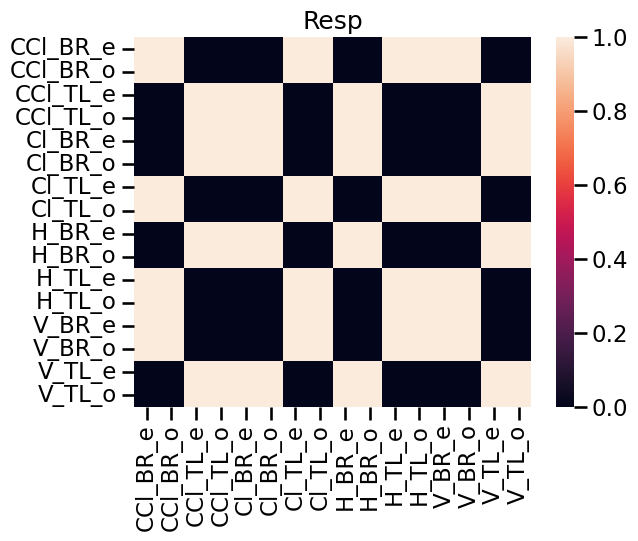

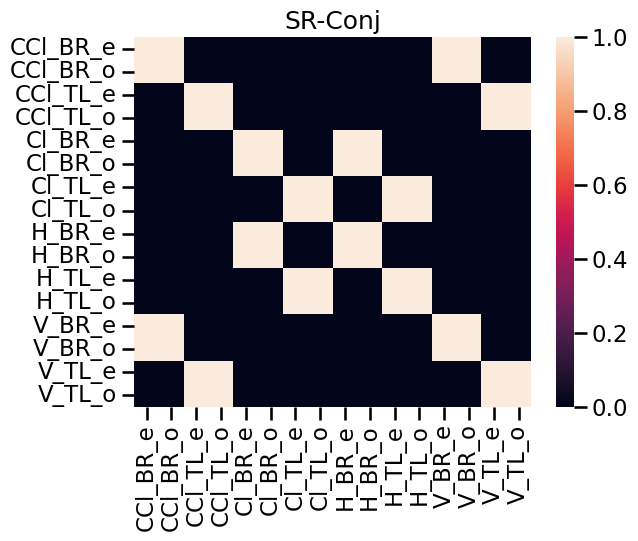

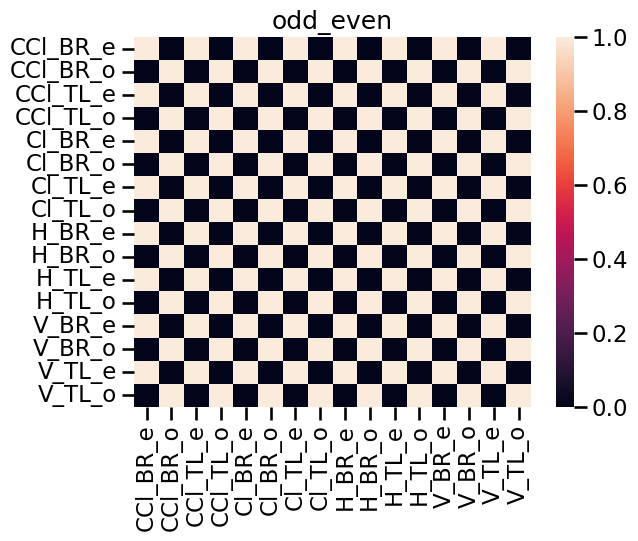

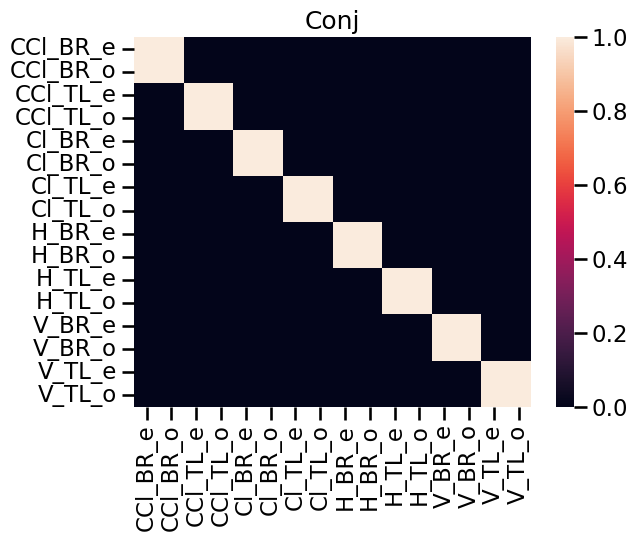

In [4]:
# Building Similarity matrices, because dealing with probabilities!
RSMs = defaultdict(lambda : np.zeros((len(cond_order), len(cond_order))))

for i, cond1 in enumerate(cond_order):
    for j, cond2 in enumerate(cond_order):
        for fac in cond_info[cond1].keys():
            if cond_info[cond1][fac] == cond_info[cond2][fac]:
                RSMs[fac][i, j] = 1
            else:
                RSMs[fac][i, j] = 0

        if cond1[:-2]==cond2[:-2]:  # matching, excluding odd-even break
            RSMs['Conj'][i, j] = 1
        else:
            RSMs['Conj'][i, j] = 0


for fac in RSMs:
    sns.heatmap(RSMs[fac], xticklabels=cond_order, yticklabels=cond_order)
    plt.title(fac)
    plt.show()

# 2 Generate Data

## Generate 2 datasets: 1 with only task/rule, stimulus, and response; 1 with only a conjuction representation (a unique & orthogonal signal per conjunction of T&S&R)
both have 16 features, of which 8 will be used to express the signals.  
Of the 3 signals in the no-conjunction dataset, the task set signal is represented most strongly, and the other 2 are much weaker (3:1:1)




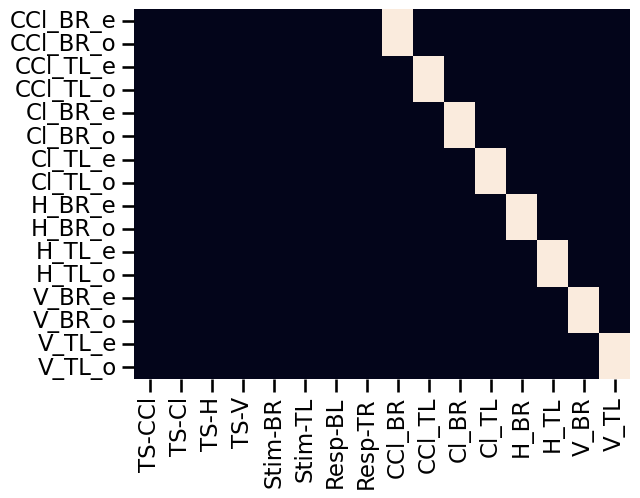

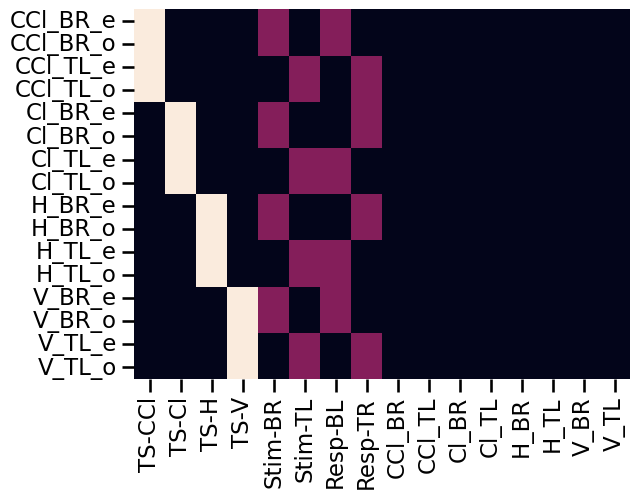

In [5]:
n_conds = len(cond_order)

n_trials_per_cond = 400

n_trials = n_conds * n_trials_per_cond

# adding n for each factor
tasks = ['CCl', 'Cl', 'H', 'V',]
stimuli = ['BR', 'TL']
responses = ['TR', 'BL']

n_dims = len(tasks) + len(stimuli) + len(responses) + int(n_conds/2) 


# Modify the #s if you want the signal strengths to differ across factors
means_conjunction = np.zeros((n_conds, n_dims))
means_noConj = np.zeros((n_conds, n_dims))

for i, cond in enumerate(cond_order):
    if i%2==0:  # adding the same signal for each even/odd pair
        means_conjunction[i:i+2, tasks.index(cond_info[cond]['Task'])] = 0
        means_conjunction[i:i+2, 4 + stimuli.index(cond_info[cond]['Stim'])] = 0
        means_conjunction[i:i+2, 6 + responses.index(cond_info[cond]['Resp'])] = 0
        means_conjunction[i:i+2, 8+int(i/2)] = 3

        means_noConj[i:i+2, tasks.index(cond_info[cond]['Task'])] = 3
        means_noConj[i:i+2, 4 + stimuli.index(cond_info[cond]['Stim'])] =1
        means_noConj[i:i+2, 6 + responses.index(cond_info[cond]['Resp'])] = 1

# see what the mean vectors look like for each condition
_ = sns.heatmap(means_conjunction,
                xticklabels=['TS-CCl', 'TS-Cl', 'TS-H', 'TS-V', 'Stim-BR', 'Stim-TL', 'Resp-BL', 'Resp-TR'] + sorted(np.unique([c[:-2] for c in cond_order])),
                yticklabels=cond_order,
                cbar=False)
plt.show()

_ = sns.heatmap(means_noConj,
                xticklabels=['TS-CCl', 'TS-Cl', 'TS-H', 'TS-V', 'Stim-BR', 'Stim-TL', 'Resp-BL', 'Resp-TR'] + sorted(np.unique([c[:-2] for c in cond_order])),
                yticklabels=cond_order,
                cbar=False)
plt.show()


# add noise
# noise is uncorrelated across features, which would be the case after LDA's internal whitening
trial_noise = np.random.multivariate_normal(np.zeros(n_dims), np.eye(n_dims)*6, size=n_trials)  # 6 indicates the relative scale of the noise; in this case it's much larger than the signal

trials_conjunction = np.zeros((n_trials, n_dims))
trials_noConj = np.zeros((n_trials, n_dims))
trial_labels = []
for i, cond in enumerate(cond_order):
    # grab the next n trials, give them the same mean based on the condition
    curr_idx = np.arange(i*n_trials_per_cond, (i+1)*n_trials_per_cond)
    # note that we are using the same noise for both datasets
    trials_conjunction[curr_idx] = trial_noise[curr_idx] + means_conjunction[i]
    trials_noConj[curr_idx] = trial_noise[curr_idx] + means_noConj[i]

    trial_labels += [cond]*n_trials_per_cond

trial_labels = np.array(trial_labels) # for easier indexing later


# 3. Fit models, get distance metrics

In [6]:
def compute_mahal(clf, test_trials):
    # Helper function to compute the Mahalanobis distance of each test trial to the training means

    # get whitening matrix from the training data
    noise = np.linalg.pinv(clf.covariance_)
    W = sqrtm(noise)

    # whiten the test dat and the training means
    W_test = (W @ test_trials.T).T

    W_train_means = (W @ clf.means_.T).T 

    distance_Nd = W_test[:, None, :] - W_train_means[None, :, :]
    distance_Nd_sqrd = distance_Nd**2
    mahal = np.sum(distance_Nd_sqrd, axis=2)  # sum across the electrodes - note, currently squared distances!
    return mahal

In [7]:
n_perms = 100
n_folds = 10

probs_conjunction = np.zeros((n_trials, n_conds, n_perms))
probs_noConj = np.zeros((n_trials, n_conds, n_perms))

dists_conjunction = np.zeros((n_trials, n_conds, n_perms))
dists_noConj = np.zeros((n_trials, n_conds, n_perms))

# for measuring performance on the task
accs_conjunction = np.zeros((n_folds, n_perms))
accs_noConj = np.zeros((n_folds, n_perms))


skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for p in range(n_perms):
    for f, (train, test) in enumerate(skf.split(trials_conjunction, trial_labels)):
        
        clf = LinearDiscriminantAnalysis(store_covariance=True)
        clf.fit(trials_conjunction[train], trial_labels[train])
        assert np.all(cond_order==clf.classes_)  # to confirm the probability vectors are going to be in the predicted order, so the order of the rows in our regressors below makes sense
        probs_conjunction[test, :, p] = clf.predict_proba(trials_conjunction[test])
        dists_conjunction[test, :, p] = compute_mahal(clf, trials_conjunction[test])
        accs_conjunction[f, p] = clf.score(trials_conjunction[test], trial_labels[test])

        clf = LinearDiscriminantAnalysis(store_covariance=True)
        clf.fit(trials_noConj[train], trial_labels[train])
        assert np.all(cond_order==clf.classes_)
        probs_noConj[test, :, p] = clf.predict_proba(trials_noConj[test])
        dists_noConj[test, :, p] = compute_mahal(clf, trials_noConj[test])
        accs_noConj[f, p] = clf.score(trials_noConj[test], trial_labels[test])


# average across the permutations
prob_means_conjunction = probs_conjunction.mean(axis=2)
prob_means_noConj = probs_noConj.mean(axis=2)

dist_means_conjunction = dists_conjunction.mean(axis=2)
dist_means_noConj = dists_noConj.mean(axis=2)

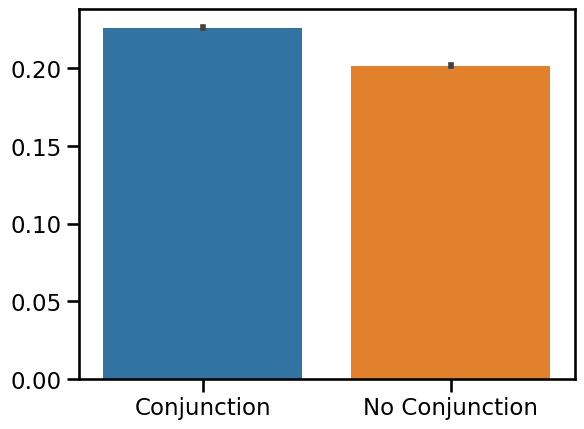

In [8]:
# check that the accuracies are somewhat reasonable

accs_noConj_means = accs_noConj.mean(0)
accs_conjunction_means = accs_conjunction.mean(0)
_ = sns.barplot(pd.DataFrame({'Conjunction': accs_conjunction_means, 'No Conjunction': accs_noConj_means}))

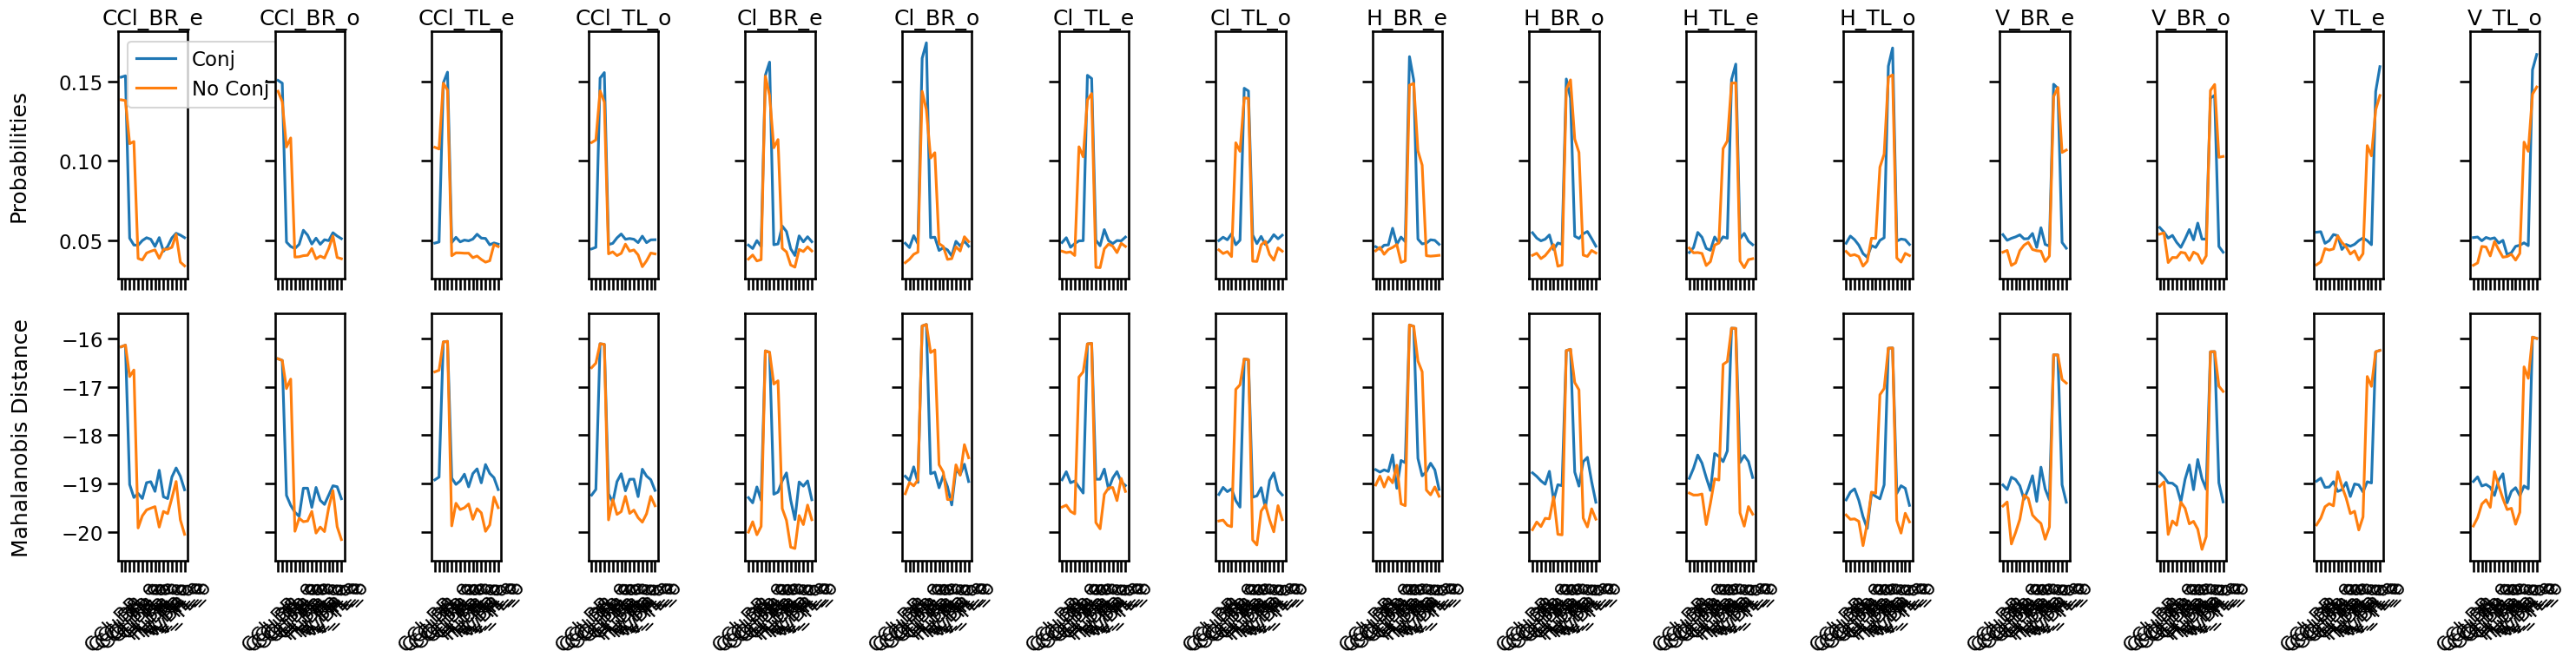

In [9]:
# Visualize the average probabilities/distances for each condition

fig, axs = plt.subplots(2, len(cond_order), figsize=(30, 8), sharex=True, sharey='row')

for c, cond in enumerate(cond_order):
    
    sns.lineplot(prob_means_conjunction[trial_labels==cond].mean(0), label='Conj', ax=axs[0, c])
    sns.lineplot(prob_means_noConj[trial_labels==cond].mean(0), label='No Conj', ax=axs[0, c])
    axs[0, c].set_xticks(range(n_conds), cond_order, rotation=45)
    axs[0, c].set_title(cond)

    sns.lineplot(-dist_means_conjunction[trial_labels==cond].mean(0), label='Conj', ax=axs[1, c])
    sns.lineplot(-dist_means_noConj[trial_labels==cond].mean(0), label='No Conj', ax=axs[1, c])
    axs[1, c].set_xticks(range(n_conds), cond_order, rotation=45)


axs[0,0].set_ylabel('Probabilities\n')
axs[1,0].set_ylabel(f'Mahalanobis Distance\n')

# turn off all legends except the first one
for ax in axs.ravel()[1:]:
    ax.get_legend().remove()

plt.tight_layout()
plt.show()

# 4. Fit linear regressions to distance metrics

In [10]:
# for each trial, we are going to predict the probabilities based on the RSMs above

res_prob_conjunction = defaultdict(list)
res_prob_noConj = defaultdict(list)

res_dist_conjunction = defaultdict(list)
res_dist_noConj = defaultdict(list)


for i, trial_label in enumerate(trial_labels):

    # 1. Fit probabilities
    trial_prob_conjunction = prob_means_conjunction[i]
    trial_prob_noConj = prob_means_noConj[i]

    trial_cond_idx = [trial_label == c for c in  cond_order]

    # build up predictors
    RSM_df = pd.DataFrame(index=cond_order)
    for fac in RSMs:
        RSM_df[fac] = np.squeeze(RSMs[fac][trial_cond_idx])
    # rescale each column to sum to 1 - shouldn't do anything, but it's what they do in the paper
    RSM_df = RSM_df / RSM_df.sum()    
    if DEMAN_REGS:
        RSM_df = RSM_df - RSM_df.mean()
    RSM_df = add_constant(RSM_df)

    # fit and save scores
    fit_tvals_conjunction = linear_model.OLS(trial_prob_conjunction, RSM_df).fit().tvalues
    fit_tvals_noConj = linear_model.OLS(trial_prob_noConj, RSM_df).fit().tvalues
    for fac in RSMs:
        res_prob_conjunction[fac].append(fit_tvals_conjunction[fac])
        res_prob_noConj[fac].append(fit_tvals_noConj[fac])

    # 2. Fit distances
    trial_dist_conjunction = dist_means_conjunction[i]
    trial_dist_noConj = dist_means_noConj[i]

    RDM_df = -RSM_df  # distances have the opposite directions predicted by the probabilities.
    RDM_df['const'] = 1  # switching back the sign of the constant term


    fit_tvals_conjunction = linear_model.OLS(trial_dist_conjunction, RDM_df).fit().tvalues
    fit_tvals_noConj = linear_model.OLS(trial_dist_noConj, RDM_df).fit().tvalues
    for fac in RSMs:
        res_dist_conjunction[fac].append(fit_tvals_conjunction[fac])
        res_dist_noConj[fac].append(fit_tvals_noConj[fac])

# 5. Visualize the average t-scores

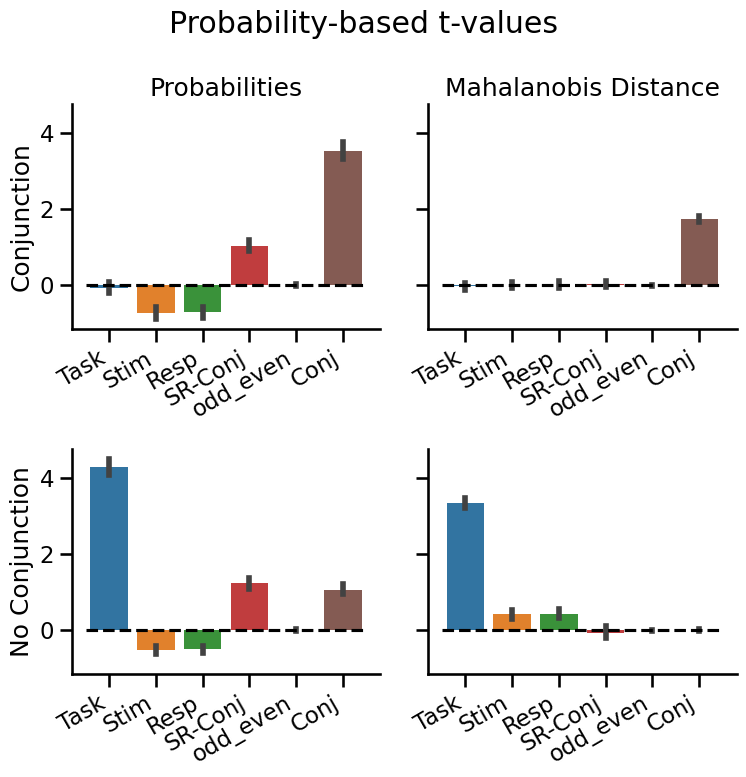

In [11]:
# create a 2X2 plot for 1) whether conjunction signals were present and 2) what distance metric was used

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
axs = axs.flatten()

for i, t_scores in enumerate([
    res_prob_conjunction,
    res_dist_conjunction,
    res_prob_noConj,
    res_dist_noConj,
]):
    _ = sns.barplot(pd.DataFrame(t_scores), ax=axs[i])
    sns.despine()
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=30, ha='right')
    axs[i].hlines(0, -.5, len(RSMs.keys())-.5, color='black', linestyle='--')

axs[0].set_title('Probabilities')
axs[1].set_title('Mahalanobis Distance')
axs[0].set_ylabel('Conjunction')
axs[2].set_ylabel('No Conjunction')

plt.suptitle('Probability-based t-values')
plt.tight_layout()
plt.show()
plt.close()

